In [1]:
import pandas as pd
import pickle
import numpy as np

p_train = r'../data/ag_train.csv'
p_test = r'../data/ag_test.csv'
df_train = pd.read_csv(p_train, header=None)
df_test = pd.read_csv(p_test, header=None)
df_train.columns = ['labels', 'title', 'data']
df_test.columns = ['labels', 'title', 'data']
print(df_train.shape, df_test.shape)
print(df_train['labels'].value_counts())
print(df_test['labels'].value_counts())

sample_df = df_train.groupby('labels').apply(lambda x: x.sample(frac=1.0, random_state=1))
print(sample_df.head())
# sample_df = sample_df.sample(frac=1)
sample_df = sample_df.sample(frac=1, random_state=1).reset_index(drop=True)
print(sample_df.shape)
print(sample_df['labels'].value_counts())
sample_df.to_csv('../data/ag_train_sample.csv')
df_train = sample_df

df_train.head()

(120000, 3) (7600, 3)
3    30000
4    30000
2    30000
1    30000
Name: labels, dtype: int64
3    1900
4    1900
2    1900
1    1900
Name: labels, dtype: int64
               labels                                              title  \
labels                                                                     
1      40546        1      Haitians Pray for 1,500 Killed by Jeanne (AP)   
       48245        1      U.S.-Led Forces Tighten Grip, Draw Complaints   
       118691       1  U.N. Says Bugging Device Found at Its Geneva H...   
       33489        1            Kerry Questions Bush's Judgment on Iraq   
       83190        1  Seoul Asks Bush to Focus on N.Korea Nuclear Cr...   

                                                            data  
labels                                                            
1      40546   AP - In a cathedral ankle-deep in mud and over...  
       48245    SAMARRA, Iraq (Reuters) - U.S.-led forces tig...  
       118691  Reuters - The United Nat

,labels,title,data
0,3,SEC plan would end exchange free rein,The nation #39;s stock exchanges would be forc...
1,1,Europe Rejects Iran's Demand to Use Uranium Eq...,Iran is demanding the right to operate uranium...
2,3,Kreme-Filled Earnings,Krispy Kreme shareholders hope for a break fro...
3,1,Ukrainian warns of protests,KIEV -- Prime Minister Viktor Yanukovych said ...
4,4,"Fishing Just for Fun Damages Stocks, Study Finds",WASHINGTON - People fishing for sport are doin...


In [2]:
df_train['raw'] = df_train['title'] + ' '+df_train['data']
df_test['raw'] = df_test['title'] + ' '+df_test['data']

# label이 1~4까지라서 => 0~3 까지로 변경해주어야 함
df_train['labels'] = df_train['labels'] - 1
df_test['labels'] = df_test['labels'] - 1

df_train

,labels,title,data,raw
0,2,SEC plan would end exchange free rein,The nation #39;s stock exchanges would be forc...,SEC plan would end exchange free rein The nati...
1,0,Europe Rejects Iran's Demand to Use Uranium Eq...,Iran is demanding the right to operate uranium...,Europe Rejects Iran's Demand to Use Uranium Eq...
2,2,Kreme-Filled Earnings,Krispy Kreme shareholders hope for a break fro...,Kreme-Filled Earnings Krispy Kreme shareholder...
3,0,Ukrainian warns of protests,KIEV -- Prime Minister Viktor Yanukovych said ...,Ukrainian warns of protests KIEV -- Prime Mini...
4,3,"Fishing Just for Fun Damages Stocks, Study Finds",WASHINGTON - People fishing for sport are doin...,"Fishing Just for Fun Damages Stocks, Study Fin..."
...,...,...,...,...
119995,1,Man U breaks off talks with Glazer,Manchester United broke off talks Monday with ...,Man U breaks off talks with Glazer Manchester ...
119996,3,Web Safety Group Launches Anti-Spyware Campaign,A prominent Internet safety organization and l...,Web Safety Group Launches Anti-Spyware Campaig...
119997,0,"Blasts, Gunfire Shake Najaf As Talks Drag","NAJAF, Iraq - Explosions and gunfire shook Naj...","Blasts, Gunfire Shake Najaf As Talks Drag NAJA..."
119998,2,Production Quota Hike Opposed by OPEC Ministers,Several OPEC members argued that the organizat...,Production Quota Hike Opposed by OPEC Minister...


# Tokenizing 미리 해서 저장해두기

- train dataset에서 vocab 추출하고
- 추출한 vocab, token2idx로 train_data 바꿔치기 하고
- train_data의 max 길이로 패딩 (BasicCollator 참조)
- train_data랑, train_labels 묶어서 ag_train.pkl 로 저장
- 마찬가지로
- 추출한 vocab, token2idx로 test_data 바꿔치기 하고
- train_data의 max 길이로 패딩 (BasicCollator 참조)
- test_data, test_labels 묶어서 ag_test.pkl 로 저장

In [3]:
from  collections import Counter
from typing import List, Tuple, Dict
from nltk.corpus import stopwords
import re


def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val, vocab=19998):
    word_list = []

    print("create vocab")
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        sent = sent.replace(r"<br />",' ')
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    print("sorting")
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:vocab]
    # creating a dict
    onehot_dict = {w:i+1 for i, w in enumerate(corpus_)}

    print('tokenizing')
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = y_train
    encoded_test = y_val

    return final_list_train, encoded_train, final_list_test, encoded_test,onehot_dict

x_train,y_train,x_test,y_test,vocab = tokenize(x_train=df_train['raw'],
                                               y_train=df_train['labels'],
                                               x_val=df_test['raw'],
                                               y_val=df_test['labels'])
print(y_train.value_counts())
print(y_test.value_counts())

create vocab
sorting
tokenizing
2    30000
0    30000
3    30000
1    30000
Name: labels, dtype: int64
2    1900
3    1900
1    1900
0    1900
Name: labels, dtype: int64


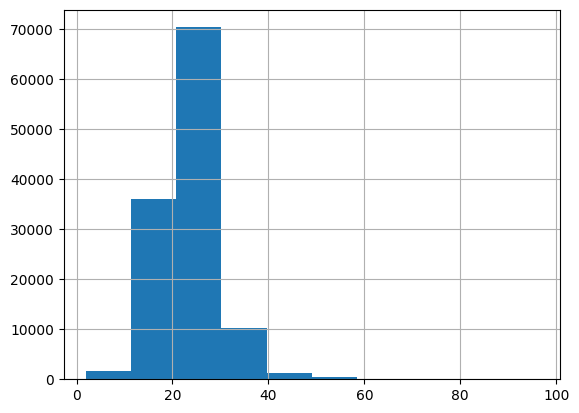

count    120000.000000
mean         23.465683
std           6.157582
min           2.000000
25%          19.000000
50%          23.000000
75%          27.000000
max          96.000000
dtype: float64

In [4]:
import matplotlib.pyplot as plt

rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [5]:
max_len = 60

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

x_train_pad = padding_(x_train,max_len)
x_test_pad = padding_(x_test,max_len)
print(len(x_train_pad), len(y_train))
print(len(x_test_pad), len(y_test))
print(len(x_train_pad[0]))

120000 120000
7600 7600
60


In [6]:
train_tokenized_idx = np.array(x_train_pad)
train_labels_np = np.array(y_train)
train_data = (train_tokenized_idx, train_labels_np)
print(train_tokenized_idx.shape)
print(train_labels_np.shape)

print('now dumping pickle')
with open(file='ag_train_sample.pkl', mode='wb') as f:
    pickle.dump(train_data, f)

(120000, 60)
(120000,)
now dumping pickle


In [7]:
test_tokenized_idx = np.array(x_test_pad)
test_labels_np = np.array(y_test)
test_data = (test_tokenized_idx, test_labels_np)
print(test_tokenized_idx.shape)
print(test_labels_np.shape)

print('now dumping test pickle')
# with open(file='ag_test.pkl', mode='wb') as f:
with open(file='ag_test_sample.pkl', mode='wb') as f:
    pickle.dump(test_data, f)

(7600, 60)
(7600,)
now dumping test pickle
